# Extended results and code explanation supporting paper *Message-Passing Neural Networks Learn Little's Law* by Krzysztof Rusek and Piotr Chołda

This *jupyter notebook* provides detailed results related to application and implementation of Neural Message-Passing for performance evaluation in Jackson networks of queues. Some of the presented ideas may be not clear until the paper is read.


First, the obtained results are given. At the end of the notebook, the full code of the implementation is discussed as well.

**If you decide to apply the concepts presented or base on the provided code, please do refer our paper: Krzysztof Rusek and Piotr Chołda, ''Message-Passing Neural Networks Learn Little's Law'', IEEE Communications Letters, 2018, *accepted for publication*.**

In [0]:
import tensorflow as tf
import numpy as np
import datetime
import argparse
import os

import graph_nn
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import IPython

In [0]:
args = graph_nn.args

In [0]:
def make_set():
    ds = tf.data.TFRecordDataset([args.eval])
    ds = ds.batch(args.batch_size)
    serialized_batch = ds.make_one_shot_iterator().get_next()
    return serialized_batch


## Confidence intervals

The confidence intervals for the test statistics are computed using the method similar to the bootstrap technique. According to the bootstrap approach, the distribution in the population is approximated by a random sampling with replacement from some set. Since we have the full generative model for the networks, we can estimate the confidence interval using the Monte Carlo method just by sampling from the whole population (instead of using the bootstrap technique). Then, the confidence intervals can be estimated as quantiles of the samples.


In [0]:
def bootstrap(ckpt_='model.ckpt-197400', nboot=9, nval=3):
    graph_nn.REUSE = None
    g=tf.Graph()

    with g.as_default():
        global_step = tf.train.get_or_create_global_step()
        with tf.variable_scope('model'):
            serialized_batch = make_set()
            batch, labels = graph_nn.make_batch(serialized_batch)
            n_batch = tf.layers.batch_normalization(batch) 
            predictions = graph_nn.inference(n_batch)

        loss= tf.losses.mean_squared_error(labels,predictions)        
        
        saver = tf.train.Saver(tf.trainable_variables() + [global_step])

    with tf.Session(graph=g) as ses:
        ses.run(tf.local_variables_initializer())
        ses.run(tf.global_variables_initializer())

        ckpt=tf.train.latest_checkpoint(args.log_dir)
        ckpt = os.path.join(args.log_dir,ckpt_ )
        print(ckpt)
        if ckpt:
            tf.logging.info("Loading checkpint: %s" % (ckpt))
            saver.restore(ses, ckpt)
        
        
        for boot_index in range(nboot):
            label_py=[]
            predictions_py=[]

            for i in range(nval):
                val_label_py, val_predictions_py, step = ses.run( [labels,
                                                                   predictions,
                                                                   global_step]
                                                                )
                label_py.append(val_label_py)
                predictions_py.append(val_predictions_py)

            label_py = np.concatenate(label_py,axis=0)
            predictions_py = np.concatenate(predictions_py,axis=0)
            yield [
                np.mean((label_py-predictions_py)**2),
                graph_nn.fitquality(label_py,predictions_py), 
                np.corrcoef(label_py,predictions_py, rowvar=False)[0,1]
            ],label_py,predictions_py

We use 99 bootstrap samples of 32 batches (with a single batch size equal to 64 samples).

In [0]:
32*64*99

202752

## Evaluation samples

All the evaluation sets are generated using commands given below. The details concerning generation of the code are provided in further parts of this notebook.

```bash
python3 samples.py -o eval.tfrecords -N 202753 -n 40 --rmax 0.9 -g ba
python3 samples.py -o eval_er.tfrecords -N 202753 -n 40 --rmax 0.9 -g er
python3 samples.py -o eval_er60.tfrecords -N 202753 -n 60 --rmax 0.9 -g er

python3 samples.py -o eval_snd_2038.tfrecords -N 202753  --rmax 0.9 -g snd \
	--sndlib sndlib/sndlib-networks-xml/cost266.graphml \
	--sndlib sndlib/sndlib-networks-xml/france.graphml \
	--sndlib sndlib/sndlib-networks-xml/geant.graphml \
	--sndlib sndlib/sndlib-networks-xml/india35.graphml \
	--sndlib sndlib/sndlib-networks-xml/janos-us.graphml \
	--sndlib sndlib/sndlib-networks-xml/nobel-eu.graphml \
	--sndlib sndlib/sndlib-networks-xml/norway.graphml \
	--sndlib sndlib/sndlib-networks-xml/sun.graphml \
	--sndlib sndlib/sndlib-networks-xml/ta1.graphml 



python3 samples.py -o eval_snd_janos-us.tfrecords -N 202753 -n 40 --rmax 0.9 -g snd \
    --sndlib sndlib/sndlib-networks-xml/janos-us.graphml

python3 samples.py -o eval_snd_janos-us-ca.tfrecords -N 202753 -n 40 --rmax 0.9 -g snd \
    --sndlib sndlib/sndlib-networks-xml/janos-us-ca.graphml

python3 samples.py -o eval_snd_cost266.tfrecords -N 202753 -n 40 --rmax 0.9 -g snd \
    --sndlib sndlib/sndlib-networks-xml/cost266.graphml

python3 samples.py -o eval_snd_germany50.tfrecords -N 202753 -n 40 --rmax 0.9 -g snd \
    --sndlib sndlib/sndlib-networks-xml/germany50.graphml
```



## Evaluation results

Below, the results are organised into sections labelled as **X**/**Y**, where __X__ describes the training set, and __Y__ describes the test set. Both **X**  and  **Y** are represented with abbreviations BA or ER (the Barabasi-Albert or Erdos-Renyi models, respectively), or a network name retrieved from the SNDLib library. For example, the section BA/ER shows the results of a model trained with Barabasi-Albert random networks, and tested on a test set drawn from the Erdos-Renyi network model.

Our best checkpoints (snapshots of the weights) based on the evaluation results are as follows (respectively for the both types of random network models):
- BA 197400
- ER 199700

All the snapshots are stored locally in subfolders of `log/`. They are not published within this notebook because of their large size. 


Each section with result analysis contains the confidence interval (95%) for mean squared error ($\mathit{MSE}$, denoted as `mse`), $\mathcal{R}^2$ (`R**2`), and Person correlation $\rho$ (`rho`) presented in a table form. The quality of the output prediction is visualized in the form of a regression plot comparing the 'true labels' (normalized delays) and the model predictions. The analysis is concluded with a histogram of residuals (i.e., model errors).



In [0]:
def print_report(bootstraps_samples):
    ci=np.percentile(bootstraps_samples,[2.5, 97.5], axis=0)
    m = np.mean(bootstraps_samples, axis=0)
    stat=np.stack([ci[0],m,ci[1]],axis=0)
    with pd.option_context('display.precision', 4):
        df = pd.DataFrame(stat,
                          columns=['mse','R**2','rho'], 
                          index=['ci_lo','mean','ci_hi'])
        IPython.display.display_html(df)


In [0]:
def print_regplots(label_py,predictions_py):
        plt.figure()
        plt.scatter(label_py,predictions_py, 
                    color="gray", 
                    facecolors='none',
                    s=1)
        l = graph_nn.line_1(label_py, label_py)
        l[0].set_color('k')
        l[0].set_linewidth(1)
        plt.grid(True,color='lightgray')
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.title('Evaluation' )
        plt.tight_layout(True)

        plt.show()
        plt.close()

        plt.figure()
        plt.hist(label_py-predictions_py,50)
        plt.title('Histogram of residuals' )
        fig_path = 'rez_hist.pdf'
        plt.show()
        plt.close()
 

## BA/BA

log/ba16/model.ckpt-197400
INFO:tensorflow:Loading checkpint: log/ba16/model.ckpt-197400
INFO:tensorflow:Restoring parameters from log/ba16/model.ckpt-197400


,mse,R**2,rho
ci_lo,0.0064,0.9923,0.9972
mean,0.0069,0.9929,0.9974
ci_hi,0.0075,0.9934,0.9976


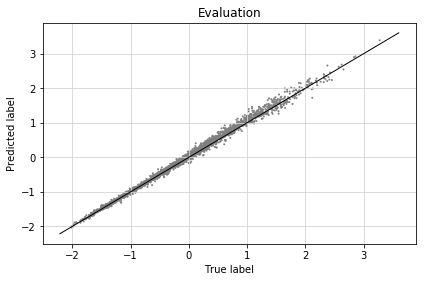

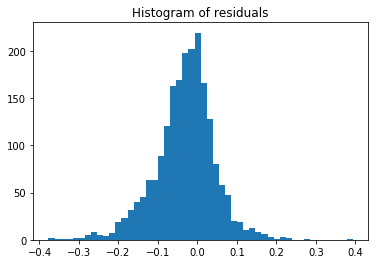

In [0]:
args.eval='eval.tfrecords'
args.log_dir = 'log/ba16'
args.ninf=16
args.rn = 8
args.W_shift=55.3
args.W_scale = 22.0 
args.mu_shift = 0.34
args.mu_scale = 0.27 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-197400', 
                                           nboot=99, 
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## BA/ER

With this exemplary results, you can note that despite there is a non-negligible bias, the correlation between true labels and model predictions is really high. Therefore, such a model can be tuned to a particular network using a small number of additional labels. This property is useful for the following procedure of transfer learning:

1. Given a trained network, compute the prediction.
1. Collect a few delays in a particular network under study.
1. Prepare a simple linear model that corrects predictions obtained form an MPNN.

log/ba16/model.ckpt-197400
INFO:tensorflow:Loading checkpint: log/ba16/model.ckpt-197400
INFO:tensorflow:Restoring parameters from log/ba16/model.ckpt-197400


,mse,R**2,rho
ci_lo,11.3472,-21.9837,0.8494
mean,11.5073,-20.2154,0.8631
ci_hi,11.6236,-18.5622,0.8748


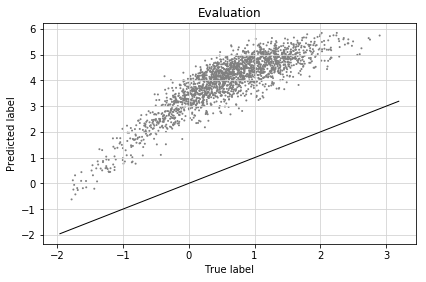

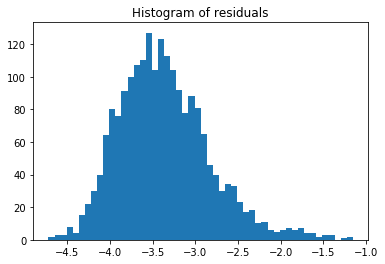

In [0]:
args.eval='eval_er.tfrecords'
args.log_dir = 'log/ba16'
args.ninf=16
args.rn = 8
args.W_shift=55.3
args.W_scale = 22.0 
args.mu_shift = 0.34
args.mu_scale = 0.27

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-197400',
                                           nboot=99, 
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

The result is likely to be biased because the mean and standard deviation of the delay in this network are not the same as for training samples for BA graphs. We can check this hypothesis by using the true values of mean and standard deviation obtained from Erdos-Renyi networks. The predictions are better, but still biased.

log/ba16/model.ckpt-197400
INFO:tensorflow:Loading checkpint: log/ba16/model.ckpt-197400
INFO:tensorflow:Restoring parameters from log/ba16/model.ckpt-197400


,mse,R**2,rho
ci_lo,8.7502,-8.5974,0.7065
mean,9.0614,-7.8326,0.7191
ci_hi,9.2678,-7.0411,0.7364


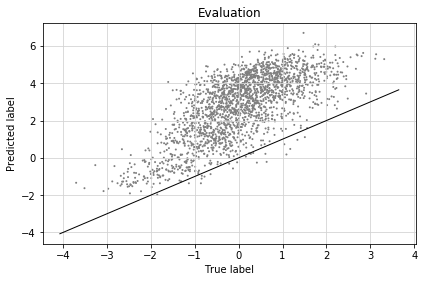

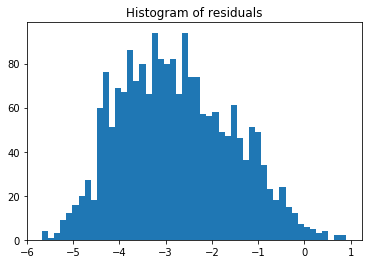

In [0]:
args.eval='eval_er.tfrecords'
args.log_dir = 'log/ba16'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 
bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-197400',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/ER

In general, the model trained with use of Erdos-Renyi networks generalizes far better in comparison to the models trained with Barabasi-Albert networks.


log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0176,0.9802,0.9937
mean,0.0188,0.9817,0.9943
ci_hi,0.0204,0.9831,0.9948


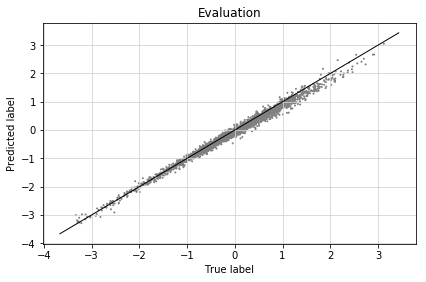

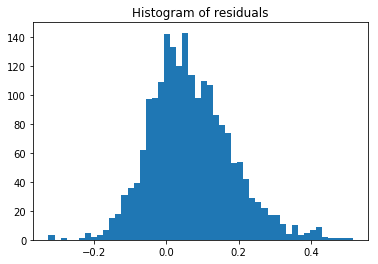

In [0]:
args.eval='eval_er.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/BA

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.1090,0.9328,0.9745
mean,0.1157,0.9371,0.9769
ci_hi,0.1251,0.9418,0.9786


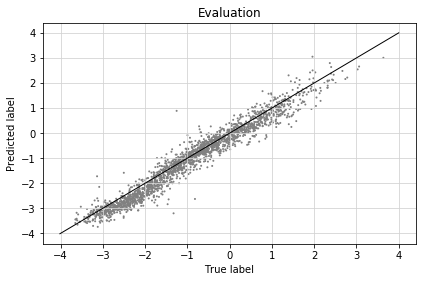

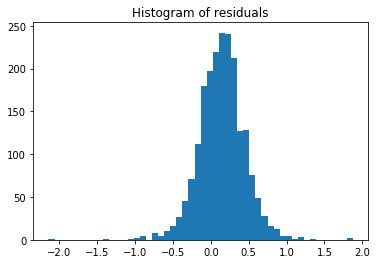

In [0]:
args.eval='eval.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/ER 60

The model based on the Erdos-Renyi networks generalizes to a larger network size, never present in the training sets.

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0951,0.9067,0.9636
mean,0.1146,0.9244,0.9715
ci_hi,0.1420,0.9369,0.9773


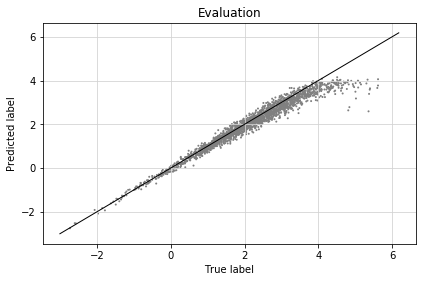

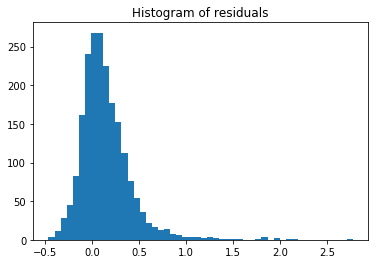

In [0]:
args.eval='eval_er60.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/ SNDLib $n\in (20,38)$

Here, we evaluate the model with the tests using some real network topologies retrieved from SNDLib. The node range $n\in (20,38)$ is most common in the whole training set (the details are provided below in the notebook).

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0671,0.9066,0.9752
mean,0.0725,0.9142,0.9776
ci_hi,0.0777,0.9219,0.9803


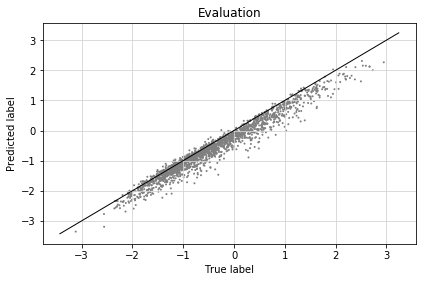

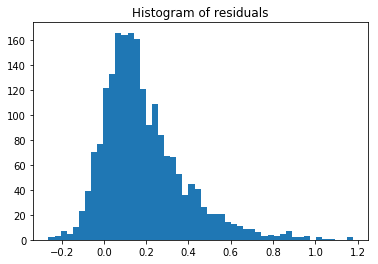

In [0]:
args.eval='eval_snd_2038.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## BA/SNDLib $n\in (20,38)$

The Barabasi-Albert networks are not useful for training if we would like to obtain high quality predictions for type of networks. However, we have noticed that BA networks provide a very interesting property. When you look at the clusters in the regression plots given below, you can note that each of five clusters is separately characterized with a large level of correlation (with a true label), although the overall correlation value is small. You can see that the 'within-cluster variance' corresponds to the variance of parameters for one particular topology; on the other hand, the 'between-cluster variance' represents the variance between topologies (__BA/germany50__ supports this claim).

Given the general model and a particular network topology, one is interested in obtaining an accurate model for this topology. Such the model can be constructed by using a small number of training samples. Since the 'within-network correlation' is high, a simple linear model is sufficient to exercise transfer learning of the topology representation from the general training set. In other words, the model can be inaccurate for some topologies. However, change of other parameters (such as traffic) results in the error at a similar level, so it can be easily corrected.



log/ba16/model.ckpt-197400
INFO:tensorflow:Loading checkpint: log/ba16/model.ckpt-197400
INFO:tensorflow:Restoring parameters from log/ba16/model.ckpt-197400


,mse,R**2,rho
ci_lo,1.4253,-2.6267,0.4700
mean,1.4945,-2.3634,0.5122
ci_hi,1.5628,-2.1410,0.5519


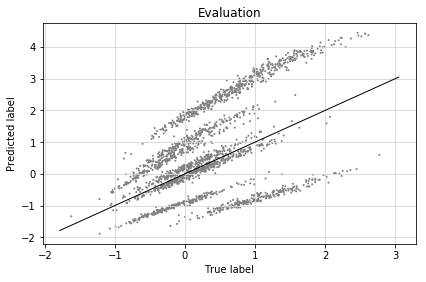

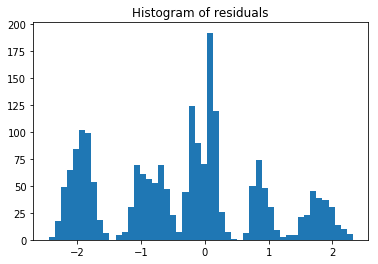

In [0]:
args.eval='eval_snd_2038.tfrecords'
args.log_dir = 'log/ba16'
args.ninf=16
args.rn = 8
args.W_shift=55.3
args.W_scale = 22.0 
args.mu_shift = 0.34
args.mu_scale = 0.27 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-197400',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/janos_us

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0192,0.9434,0.9884
mean,0.0206,0.9468,0.9893
ci_hi,0.0222,0.9499,0.9900


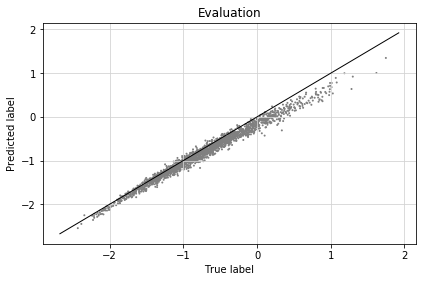

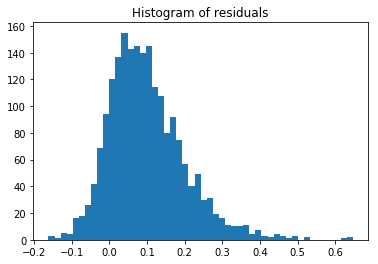

In [0]:
args.eval='eval_snd_janos-us.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/janos_us_ca

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0399,0.9215,0.9833
mean,0.0427,0.9259,0.9845
ci_hi,0.0454,0.9309,0.9857


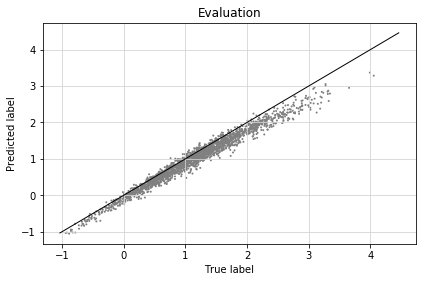

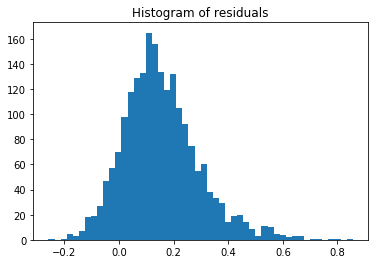

In [0]:
args.eval='eval_snd_janos-us-ca.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/cost266

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.0326,0.9321,0.9861
mean,0.0350,0.9362,0.9872
ci_hi,0.0374,0.9413,0.9884


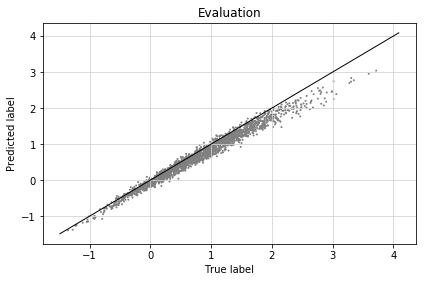

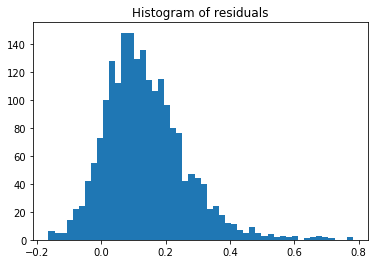

In [0]:
args.eval='eval_snd_cost266.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## ER/germany50

log/er3/model.ckpt-199700
INFO:tensorflow:Loading checkpint: log/er3/model.ckpt-199700
INFO:tensorflow:Restoring parameters from log/er3/model.ckpt-199700


,mse,R**2,rho
ci_lo,0.1791,0.7161,0.9434
mean,0.1946,0.7374,0.9531
ci_hi,0.2131,0.7572,0.9590


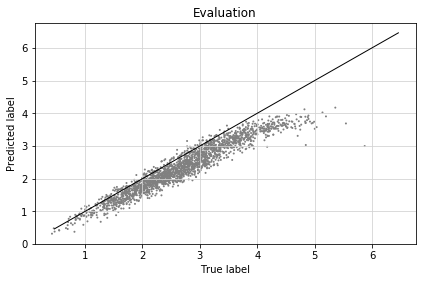

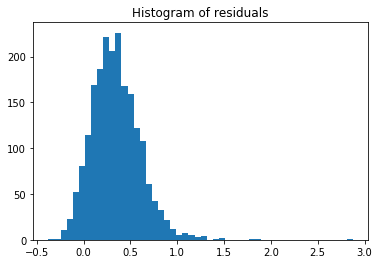

In [0]:
args.eval='eval_snd_germany50.tfrecords'
args.log_dir = 'log/er3'
args.ninf=16
args.rn = 8
args.W_shift=69.3
args.W_scale = 15.95 
args.mu_shift = 0.199
args.mu_scale = 0.12 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-199700',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

## BA/germany50

Again, a large systematic error can be observed in this case. Nevertheless, a large correlation that can be corrected by a simple linear model is also noticeable. Generally, it can be observed that only a small number of samples from `germany50`(where traffic is randomized) is required to train a highly accurate model for this particular topology.

log/ba16/model.ckpt-197400
INFO:tensorflow:Loading checkpint: log/ba16/model.ckpt-197400
INFO:tensorflow:Restoring parameters from log/ba16/model.ckpt-197400


,mse,R**2,rho
ci_lo,2.2272,-5.1083,0.9400
mean,2.2480,-4.7743,0.9433
ci_hi,2.2660,-4.4130,0.9461


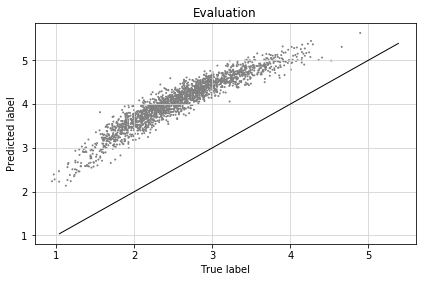

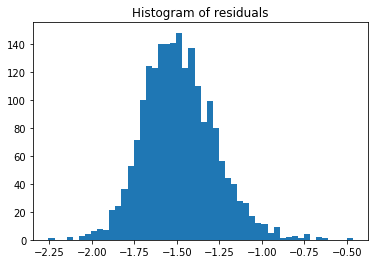

In [0]:
args.eval='eval_snd_germany50.tfrecords'
args.log_dir = 'log/ba16'
args.ninf=16
args.rn = 8
args.W_shift=55.3
args.W_scale = 22.0 
args.mu_shift = 0.34
args.mu_scale = 0.27 

bootstraps_samples = []
for b,label_py,predictions_py in bootstrap(ckpt_='model.ckpt-197400',
                                           nboot=99,
                                           nval=32):
    bootstraps_samples.append(b)
    
bootstraps_samples = np.asarray(bootstraps_samples)
print_report(bootstraps_samples)
print_regplots(label_py,predictions_py)

# Implementation Details
This section describes low-level details related to our implementation of the MPNN. The full code presented below will be made publicly available via *Github* and in the form of this *Jupyter notebook*.

## Random Graph Model

Example usage:

```python3 samples.py -o eval.tfrecords -N 2000 -n 40 --rmax 0.9 -g ba```

In [0]:
# %load samples.py
import networkx as nx
import numpy as np
import  scipy as sp
import tensorflow as tf
import argparse
import datetime
import glob
import os
import sys

sndlib_networks = None

class GraphProvider:
    def get(self):
        G = self._get()
        G=nx.convert_node_labels_to_integers(G)
        return G

class BarabasiAlbert(GraphProvider):
    def __init__(self,n):
        self.n = n
        self.nmin=10
        self.m = 2
    def _get(self):
        return nx.barabasi_albert_graph(np.random.randint(self.nmin,self.n),
                                        self.m)

class ErdosReni(GraphProvider):
    def __init__(self,n):
        self.n = n
        self.p =  2.0/n
    def _get(self):
        G=nx.fast_gnp_random_graph(self.n,self.p,directed=False)
        largest_cc = max(nx.connected_components(G), key=len)
        Gm=G.subgraph(largest_cc)
        return Gm

class SNDLib(GraphProvider):
    def __init__(self,flist):
        self.sndlib_networks = {os.path.split(f)[1][0:-8]:nx.read_graphml(f)
                                for f in flist}
        self.names = list(self.sndlib_networks.keys())

    def _get(self):
        name = np.random.choice(self.names)
        Gm = nx.Graph( self.sndlib_networks[name] )
        return Gm


def make_sample(provider, rl=0.3, rh=0.7):
    Gm=provider.get()
    A=nx.convert_matrix.to_numpy_matrix(Gm)

    # Make all intensities addup to 1
    L=np.random.uniform(size=(len(Gm),1))
    L = L /np.sum(L)
    p=1.0/(np.sum(A,axis=1)+1.0)
    R=np.multiply(A,p)


    lam=np.linalg.solve(np.identity(len(Gm))-np.transpose( R ) ,L)
    #random utilisation of each node
    rho=np.random.uniform(low=rl,high=rh, size=lam.shape)

    mu = lam/rho
    ll=rho/(1-rho)
    W=np.sum(ll)/np.sum(L)

    #  Max value of W is of order n*0.99/(1 -0.99)

    nx.set_node_attributes(Gm, 
                           name='mu', 
                           values=dict(zip(Gm.nodes(),
                                           np.ndarray.tolist(mu[:,0]))))
    nx.set_node_attributes(Gm, 
                           name='Lambda', 
                           values=dict(zip(Gm.nodes(),
                                           np.ndarray.tolist(L[:,0]))))
    it=np.nditer(R, order='F', flags=['multi_index'])
    at = {it.multi_index:float(x) for x in it if x > 0}
    nx.set_edge_attributes(Gm,name='R', values=at)
    Gm.graph['W']=W

    return mu,L,R,W,Gm

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def make_dataset(count, file, producer):
    writer = tf.python_io.TFRecordWriter(file)
    for i in range(count):
        if not i % 500:
            print('{} generated'
                  ' {} samples.'.format(str(datetime.datetime.now()),
                                                    i ) )

        mu,L,R,W,Gm=producer()
        #while W > 3.3:
        #    mu,L,R,W,Gm=make_sample(n,p)

        mu = mu[:,0].tolist()
        L = L[:,0].tolist()
        first,last=np.nonzero(R)
        e=R[first,last].tolist()[0]

        example = tf.train.Example(features=tf.train.Features(feature={
            'mu': _float_feature(mu),
            'Lambda': _float_feature(L),
            'W':_float_feature([W]),
            'R':_float_feature(e),
            'first':_int64_feature(first.tolist()),
            'second':_int64_feature(last.tolist()) }))
        writer.write(example.SerializeToString())
    writer.close()


if __name__ =='__main__':
    random_org_help='''Seed, if none, downloads from random.org'''

    parser = argparse.ArgumentParser(description='Generates saple networks')
    parser.add_argument('-N', help='number of samples',  
                        required=True, type=int)
    parser.add_argument('-n', help='number of nodes',  default=40, type=int)
    parser.add_argument('-o', help='Output file',  required=True, type=str)
    parser.add_argument('--rmin', help='Min rho',  type=float, default=0.3)
    parser.add_argument('--rmax', help='max rho',  type=float, default=0.7)
    parser.add_argument('-s', help=random_org_help,  required=False, type=int)
    parser.add_argument('-g', help='random graph type: [ba | er | snd]',  
                        type=str, default="ba")
    parser.add_argument('--sndlib', help='Sndlib files',  type=str ,nargs='+')
    args = parser.parse_args()

    if args.s is None:
        import urllib.request
        with urllib.request.urlopen(
            'https://www.random.org/integers/?'
            'num=1&min=0&max=1000000&'
            'col=1&base=10&format=plain&rnd=new') as response:
            rnd_seed = int(response.read())
            print( str(datetime.datetime.now()),
                  "Random response: {}".format(rnd_seed))
            np.random.seed(rnd_seed)
    else:
        np.random.seed(args.s)
    provider = None
    if args.g == 'er':
        provider = ErdosReni(args.n)
    elif args.g == 'ba':
        provider = BarabasiAlbert(args.n)
    elif args.g == 'snd':
        provider = SNDLib(args.sndlib)
    

    make_dataset(args.N,args.o, lambda: make_sample(provider, 
                                                    args.rmin, 
                                                    args.rmax))

## Statistics

Here we present how selected statistics related to the used random networks can be acquired. It is important to use the data properly normalized (so that they are characterized with zero mean and unit standard deviation) as it helps with the training process.

In [0]:
def set_stat(filename):
    gL=[]
    gM=[]
    gW=[]
    geW=[]
    gR=[]
    nnodes=[]
    r=tf.python_io.tf_record_iterator(filename)
    for be in r:
        e = tf.train.Example()
        e.ParseFromString(be)
        Lambda=e.features.feature["Lambda"].float_list.value
        mu=e.features.feature["mu"].float_list.value
        R=e.features.feature["R"].float_list.value
        first=e.features.feature["first"].int64_list.value
        second=e.features.feature["second"].int64_list.value
        W=e.features.feature["W"].float_list.value[0]


        gL += Lambda
        gM += mu
        gW.append(W)
        gR += R
        nnodes.append(len(Lambda))
    return gL,gW,gM, nnodes
    
def vis_set(gL,gW,gM, nnodes):
    stats=pd.DataFrame({
        'Delay':{f.__name__:f(gW) for f in [np.mean, np.std]},
    'Traffic':{f.__name__:f(gL) for f in [np.mean, np.std]},
    'Serice':{f.__name__:f(gM) for f in [np.mean, np.std]}
    })
    IPython.display.display_html(stats)
    plt.hist(gW,50);
    plt.title('Histogram of the delay');
    plt.figure()
    plt.hist(nnodes,30);
    plt.title('Network size Histogram')

#### Erdos-Renyi

Most of the training samples are contained in the range $(20,38)$.

,Delay,Traffic,Serice
mean,69.192608,0.032427,0.198637
std,16.220034,0.020412,0.117274


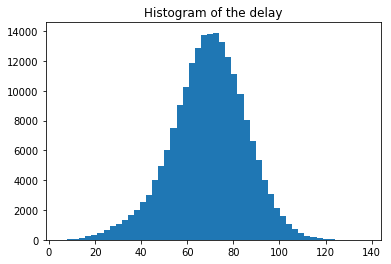

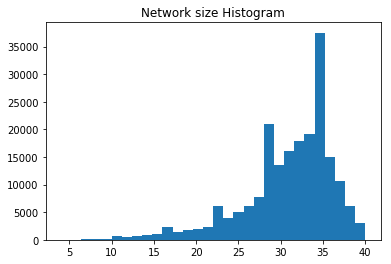

In [0]:
gL,gW,gM, nnodes = set_stat('eval_er.tfrecords')
vis_set(gL,gW,gM, nnodes)

#### Barabasi-Albert

,Delay,Traffic,Serice
mean,54.978299,0.040796,0.345124
std,21.641997,0.030280,0.266778


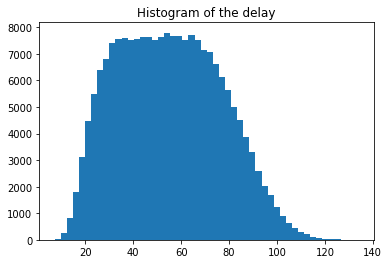

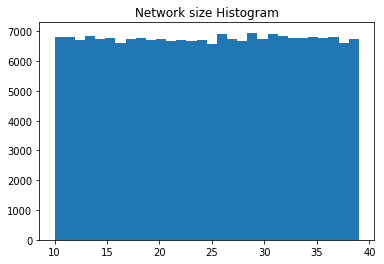

In [0]:
gL,gW,gM, nnodes = set_stat('eval.tfrecords')
vis_set(gL,gW,gM, nnodes)

## Tensorflow Implementation of MPNN

NOTE: This code is to be run via CLI as a script not as a notebook cell (see below for instructions)!

### Training options

Below, we provide the hyper-parameters we have found optimal for the task. Most of the hyper-parameters are encoded with default values for the training script options.

#### ba16

```bash 
sbatch -J ba16 -t 72:0:0 ./train.sh --rn 8 --train train.tfrecords --test test.tfrecords --buf 10000 --buf 10000 --ninf 16 -I 200000  
```



#### er3

```bash
sbatch -J er3 -t 72:0:0 ./train.sh --rn 8 --train train_er.tfrecords --test test_er.tfrecords --buf 10000 --W-shift 69.3 --W-scale 15.95 --mu-shift 0.199 --mu-scale 0.12 --buf 10000 --ninf 16 -I 200000  

```


In [0]:
# %load graph_nn.py
import tensorflow as tf
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import datetime
import argparse
import os
import io

parser = argparse.ArgumentParser(description='Train the graph neural network')
parser.add_argument('--pad', help='extra padding for node embeding',  type=int, 
                    default=12)
parser.add_argument('--pas', help='number of passes',  type=int, default=4)
parser.add_argument('--batch_size', help='batch_size',  type=int, default=64)
parser.add_argument('--lr', help='learning rate',  type=float, default=0.001)
parser.add_argument('--log_dir', help='log dir',  type=str, default='log')
parser.add_argument('--rn', help='number of readout neurons',  type=int, 
                    default=8)
parser.add_argument('--buf', help='buffer',  type=int, default=200)
parser.add_argument('-I', help='number of iteration',  type=int, default=80000)
parser.add_argument('--eval', help='evaluatioin file',  type=str, 
                    default='eval.tfrecords')
parser.add_argument('--train', help='train file',  type=str, 
                    default='train.tfrecords')
parser.add_argument('--test', help='test file',  type=str, 
                    default='test.tfrecords')
parser.add_argument('--ninf', 
                    help='Number of hidden neurions in inference layer', 
                    type=int, default=256)
parser.add_argument('--Mhid', 
                    help='Number of hidden neurons in message layer', 
                    type=int, default=8)

def stat_args(name, shift=0,scale=1):
    parser.add_argument('--{}-shift'.format(name), 
        help='Shift  for {} (usualy np.mean)'.format(name) ,  
        type=float, default=shift)

    parser.add_argument('--{}-scale'.format(name), 
        help='Scale  for {} (usualy np.std)'.format(name) ,  
        type=float, default=scale)

stat_args('mu',shift=0.34, scale=0.27)
stat_args('W',shift=55.3, scale=22.0)

if __name__ == '__main__':
    args = parser.parse_args()
else:
    args = parser.parse_args([])

def test():
    return args.I

N_PAD=args.pad
N_PAS=args.pas
N_H=2+N_PAD
REUSE=None
batch_size=args.batch_size

#### MPNN

Below, we present the code implementing message-passing neural network. The algorithm is described in the paper, here we only give its basic mathematical sketch.

Message: $$ \mathbf m_v^{t+1} = \sum_{w\in{N(v)}} M_t\left(\mathbf h_v^t,\mathbf h_w^t,\mathbf e_{vw}\right) \quad t=1,\dots,T,$$

Update: $$\mathbf h_v^{t+1} = U_t\left(\mathbf h_v^t,\mathbf m_v^{t+1}\right) \quad t=0,1,\dots,T,$$

$$\mathbf h_v^0=[\mathbf x_v,0,\ldots, 0]$$

Readout: $$\hat{\mathbf y} = R(\mathbf h)$$

The implementation is very low-level and uses only basic tensorflow options. A high-level implementation based on `tf.keras` and `tf.estimators` will be provided in the future to enable users to operate easily. However, we would like to stress that the presented implementation does provide the full assumed functionality.

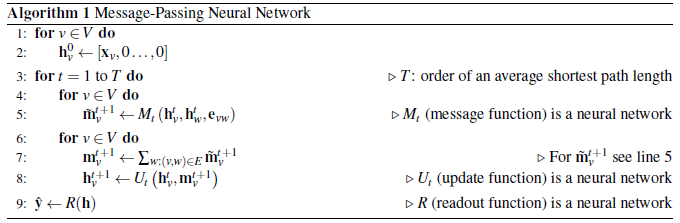

##### Message function

The message function is a neural network parametrized affine function.
We use the SELU activation function because of its good scaling properties.

For more details on `selu`, see for instance paper by Klambauer et al. "Self-Normalizing Neural Networks", 31st Conference on Neural Information Processing Systems NIPS 2017 ([arXiv:1706.02515v5](https://arxiv.org/abs/1706.02515)).

In [0]:
def M(h,e):
    with tf.variable_scope('message'):
        bs = tf.shape(h)[0]
        l = tf.layers.dense(e,args.Mhid ,activation=tf.nn.selu)
        l = tf.layers.dense(l,N_H*N_H)
        l=tf.reshape(l,(bs,N_H,N_H))
        m=tf.matmul(l,tf.expand_dims(h,dim=2) )
        m=tf.reshape(m,(bs,N_H))
        b = tf.layers.dense(e,args.Mhid ,activation=tf.nn.selu)
        b = tf.layers.dense(b,N_H)
        m = m + b


        return m
    

##### Update function

The update function is based on a custom implementation of a GRU (Gated Recurrent Unit) recurrent neural network. 
The reason for this is that GRU is simpler in comparison to LSTM (i.e., there is no output gate) and has fewer parameters. This is a recurrent unit that has an internal structure that by design reuses weights (i.e., weight tying) for every element in the sequence. We tried  using different units for subsequent t in the experiments, but the training was much longer without noticeable improvement of accuracy.

For more details on `GRU`, see for instance paper by Chung et al. "Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling", 28th Conference on Neural Information Processing Systems NIPS 2014 ([arXiv:1409.1259v2](https://arxiv.org/pdf/1412.3555.pdf))

In [0]:
def U(h,m,x):
    init = tf.truncated_normal_initializer(stddev=0.01)
    with tf.variable_scope('update'):
        wz=tf.get_variable(name='wz',shape=(N_H,N_H),dtype=tf.float32)
        uz=tf.get_variable(name='uz',shape=(N_H,N_H),dtype=tf.float32)
        wr=tf.get_variable(name='wr',shape=(N_H,N_H),dtype=tf.float32)
        ur=tf.get_variable(name='ur',shape=(N_H,N_H),dtype=tf.float32)
        W=tf.get_variable(name='W',shape=(N_H,N_H),dtype=tf.float32)
        U=tf.get_variable(name='U',shape=(N_H,N_H),dtype=tf.float32)
        
        z = tf.nn.sigmoid(tf.matmul(m,wz) + tf.matmul(h,uz))
        r = tf.nn.sigmoid(tf.matmul(m,wr) + tf.matmul(h,ur))
        h_tylda = tf.nn.tanh(tf.matmul(m,W) + tf.matmul(r*h,U) )
        u = (1.0-z)*h + z*h_tylda
        return u

##### Readout function

The readout function is obtained just as a neural network with attention.
By 'attention' we mean the mechanism in the neural network allowing it to learn what information is important in a given input. In our readout function, the output of the network $j$ is multiplied with an output of network $i$ processed by the `sigmoid` activation function at the output. The sigmoid function takes values in the range $(0,1)$. Multiplication by such a number acts as a gate selecting the important parts of the output from $j$ for the final summation.

In [0]:
def R(h,x):
    with tf.variable_scope('readout'):
        hx=tf.concat([h,x],axis=1)
        i = tf.layers.dense(hx,args.rn,activation=tf.nn.tanh)
        i = tf.layers.dense(i,args.rn)
        j = tf.layers.dense(h,args.rn,activation=tf.nn.selu)
        j = tf.layers.dense(j,args.rn)

        RR = tf.nn.sigmoid(i)
        RR = tf.multiply(RR,j)

        return tf.reduce_sum(RR,axis=0)

The Python function ```graph_features```, given below, exercises message-passing phases on a graph and produces a vector representation of a network.

In [0]:
def graph_features(x,e,first,second):
    global REUSE
    
    h=tf.pad(x,[[0,0],[0,N_PAD]])

    initializer =tf.contrib.layers.xavier_initializer()
    for i in range(N_PAS):
        with tf.variable_scope('features',
        reuse=REUSE, 
        initializer=initializer,
        ) as scope:
            m=M(tf.gather(h,first),e)
            num_segments=tf.cast(tf.reduce_max(second)+1,tf.int32)
            m = tf.unsorted_segment_sum(m,second,num_segments)
            h = U(h,m,x)

            REUSE=True
        

    return R(h,x)

At this point, the network is represented by a vector. Therefore, we can pass it through a neural network for inference (forward pass).

In [0]:
def inference(batch,reuse=None):
    initializer =tf.contrib.layers.xavier_initializer()
    with tf.variable_scope("inference",
    reuse=reuse,
    initializer=initializer):
        l=batch
        l=tf.layers.dense(l, args.ninf, activation=tf.nn.selu)
        l=tf.layers.dense(l,1)
        return l
    
def make_batch(serialized_batch):
    bs = tf.shape(serialized_batch)[0]

    to=tf.TensorArray(tf.float32,size=bs)
    labelto=tf.TensorArray(tf.float32,size=bs)

    condition = lambda i,a1,a2: i < bs
    def body(i,to,lto):
        with tf.device("/cpu:0"):
            #unpack 
            with tf.name_scope('load'):    
                features = tf.parse_single_example(
                serialized_batch[i],
                features={
                    'mu': tf.VarLenFeature(tf.float32),
                    "Lambda": tf.VarLenFeature( tf.float32),
                    "W":tf.FixedLenFeature([],tf.float32),
                    "R":tf.VarLenFeature(tf.float32),
                    "first":tf.VarLenFeature(tf.int64),
                    "second":tf.VarLenFeature(tf.int64)})

                ar=[(tf.sparse_tensor_to_dense(features['mu'])
                     -args.mu_shift)/args.mu_scale,
                        (tf.sparse_tensor_to_dense(features['Lambda']))]
                x=tf.stack(ar,axis=1)

                e=tf.sparse_tensor_to_dense(features['R'])

                e = tf.expand_dims(e,axis=1)

                first=tf.sparse_tensor_to_dense(features['first'])
                second=tf.sparse_tensor_to_dense(features['second'])
            
        g_feature = graph_features(x,e,first,second) 
        W = (features['W']-args.W_shift)/args.W_scale # 0.7-0.9

        return i+1,to.write(i,g_feature ),lto.write(i,W)
    
    with tf.control_dependencies([serialized_batch]):
        _,batch,labelst = tf.while_loop(condition,body,[tf.constant(0),
                                                        to,
                                                        labelto])
        batch = batch.stack()
        labels = labelst.stack()
        labels = tf.reshape(labels,[bs,1])
    return batch, labels
def make_trainset():
    filename_queue = tf.train.string_input_producer( [args.train])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    serialized_batch= tf.train.shuffle_batch( [serialized_example],
                                             batch_size=batch_size, 
                                             capacity=args.buf, 
                                             min_after_dequeue=batch_size, 
                                             num_threads=2)
    return serialized_batch
def make_testset():
    filename_queue = tf.train.string_input_producer( [args.test])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    serialized_batch= tf.train.batch( [serialized_example], batch_size=200)
    
    return serialized_batch

def line_1(x1,x2):
    xmin=np.min(x1.tolist()+x2.tolist())
    xmax=np.max(x1.tolist()+x2.tolist())
    lines = plt.plot([1.1*xmin,1.1*xmax],[1.1*xmin,1.1*xmax])
    return lines

def fitquality (y,f):
    '''
    Computes $R^2$
    Args:
        x true label
        f predictions
    '''
    ssres=np.sum((y-f)**2)
    sstot=np.sum( (y-np.mean(y))**2 )
    R2 = 1-ssres/sstot

    return R2

Below, the main training part is presented. We run message-passing on a graph, then perform the forward pass of the inference and compute $MSE$ loss for the delay. The loss backpropagates and the weights of $M$, $U$, and $R$ networks are updated.

In [0]:
if __name__== "__main__":
    
    if not os.path.exists(args.log_dir):
        os.makedirs(args.log_dir)

    REUSE=None
    g=tf.Graph()

    with g.as_default():
        global_step = tf.train.get_or_create_global_step()
        with tf.variable_scope('model'):
            serialized_batch = make_trainset()
            batch, labels = make_batch(serialized_batch)
            n_batch = tf.layers.batch_normalization(batch) 
            predictions = inference(n_batch)

        loss= tf.losses.mean_squared_error(labels,predictions)        
        rel = tf.reduce_mean(tf.abs( (labels-predictions)/labels) )

        trainables = tf.trainable_variables()
        grads = tf.gradients(loss, trainables)
        grad_var_pairs = zip(grads, trainables)
        
        summaries = [tf.summary.histogram(var.op.name, var) for var
                     in trainables]
        summaries += [tf.summary.histogram(g.op.name, g) for g
                      in grads if g is not None]
        summaries.append(tf.summary.scalar('train_mse', loss)) 
        summary_op = tf.summary.merge(summaries)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train=tf.train.RMSPropOptimizer(learning_rate=0.001
                                           ).minimize(loss,
                                                      global_step=global_step)

        # Evaluation
        with tf.variable_scope('model', reuse=True):
            test_batch, test_labels = make_batch(make_testset()) 
            test_batch = tf.layers.batch_normalization(test_batch,reuse=True)
            test_predictions = inference(test_batch,reuse=True)
        test_relative = tf.abs( (test_labels-test_predictions)/
                               (test_labels + args.W_shift/args.W_scale ) )
        mare = tf.reduce_mean(test_relative)

        test_summaries = [tf.summary.histogram('test_relative_absolute_error', 
                                               test_relative)]

        test_summaries.append(tf.summary.scalar('test_mse', 
                                    tf.reduce_mean(
                                        (test_labels-test_predictions)**2 ) ) )
        test_summary_op = tf.summary.merge(test_summaries)
        
        saver = tf.train.Saver(trainables + [global_step])

    with tf.Session(graph=g) as ses:
        ses.run(tf.local_variables_initializer())
        ses.run(tf.global_variables_initializer())

        ckpt=tf.train.latest_checkpoint(args.log_dir)
        if ckpt:
            print("Loading checkpint: %s" % (ckpt))
            tf.logging.info("Loading checkpint: %s" % (ckpt))
            saver.restore(ses, ckpt)



        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=ses, coord=coord)
        writer=tf.summary.FileWriter(args.log_dir, ses.graph)

        try:
            while not coord.should_stop():
                    _,mse_loss,summary_py, step = ses.run([train,
                                                           loss,
                                                           summary_op,
                                                           global_step])
                    writer.add_summary(summary_py, global_step=step)

                    if step % 100 ==0:
                        test_label_py, 
                        test_predictions_py, 
                        test_summary_py = ses.run([test_labels,
                                                   test_predictions,
                                                   test_summary_op])
                        test_error = test_predictions_py-test_label_py
                        R2 = fitquality(test_label_py,test_predictions_py)

                        print('{} step: {} train_mse: {},'
                              ' test_mse: {} R**2: {}'.format(
                            str(datetime.datetime.now()),
                            step,
                            mse_loss,
                            np.mean(test_error**2),
                            R2 ), flush=True ) 
                        
                        writer.add_summary(test_summary_py, global_step=step)

                        checkpoint_path = os.path.join(args.log_dir,
                                                       'model.ckpt')
                        saver.save(ses, checkpoint_path, global_step=step)
                        #make scatter plot
                        fig = plt.figure()
                        plt.plot(test_label_py,test_predictions_py,'.')
                        line_1(test_label_py, test_label_py)
                        plt.xlabel('test label')
                        plt.ylabel('test predictions')
                        plt.title(str(step))

                        with io.BytesIO() as buf:
                            w,h = fig.canvas.get_width_height()
                            plt.savefig(buf, format='png')
                            buf.seek(0)
                            plt.close()
                            summary = tf.Summary(value= [
                                tf.Summary.Value( tag="regression",
                                    image=tf.Summary.Image(height = h,
                                         width =w, 
                                         colorspace =3 , 
                                         encoded_image_string = buf.read()) ),
                                tf.Summary.Value(tag="R2", simple_value=R2)
                                ])
                            writer.add_summary(summary, global_step=step)



                    if step > args.I:
                        coord.request_stop()
        except tf.errors.OutOfRangeError:
            print('OutOfRange' )

        finally:
            coord.request_stop()

        coord.join(threads)
        writer.flush()
        writer.close()